In [1]:
!pip install imbalanced-learn
!pip install --upgrade numexpr

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = 'End_dataframe.csv' 
data = pd.read_csv(file_path)

# Features and target
X = data[['Gender', 'Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]
y = data['VVR_Encoded']  

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Random Forest model and parameter grid for Grid Search
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.001, 0.01, 0.1, 1]
}

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled.drop(columns='Gender'), y_train_resampled)

# Print the best parameters and the best score
print("\nOptimal Parameters from Grid Search:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

# Best model from Grid Search
best_rf = grid_search.best_estimator_

# Make predictions on the test set and training set
y_pred_test = best_rf.predict(X_test.drop(columns='Gender'))
y_pred_train = best_rf.predict(X_train_resampled.drop(columns='Gender'))

# Evaluate the model on the test set
print("\nTest Set Performance:")
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

# Additional metrics for the test set
mcc_test = matthews_corrcoef(y_test, y_pred_test)
print(f"MCC (Test): {mcc_test:.2f}")

# Evaluate the model on the training set
print("\nTraining Set Performance:")
print("\nConfusion Matrix (Training Set):")
print(confusion_matrix(y_train_resampled, y_pred_train))
print("\nClassification Report (Training Set):")
print(classification_report(y_train_resampled, y_pred_train))

# Additional metrics for the training set
mcc_train = matthews_corrcoef(y_train_resampled, y_pred_train)
print(f"MCC (Train): {mcc_train:.2f}")

# Gender-wise analysis for test set
class_labels = {0: 'Low_VVR', 1: 'High_VVR'}
gender_labels = {1: 'Male', 2: 'Female'}

X_test['y_test'] = y_test  
X_test['y_pred'] = y_pred_test  

print("\nTest Set Performance by Gender:")
test_gender_groups = X_test.groupby('Gender')
for gender, group in test_gender_groups:
    gender_name = gender_labels.get(gender, gender)
    true_labels = group['y_test']
    predicted_labels = group['y_pred']
    print(f"\nGender: {gender_name}")
    print(confusion_matrix(true_labels, predicted_labels, labels=[0, 1]))
    print(classification_report(true_labels, predicted_labels, target_names=['Low_VVR', 'High_VVR']))
    print(f"MCC: {matthews_corrcoef(true_labels, predicted_labels):.2f}")

# Gender-wise analysis for training set
print("\nTraining Set Performance by Gender:")
X_train_resampled['y_train'] = y_train_resampled  # Add true labels
X_train_resampled['y_pred'] = y_pred_train  # Add predictions

train_gender_groups = X_train_resampled.groupby('Gender')
for gender, group in train_gender_groups:
    gender_name = gender_labels.get(gender, gender)
    true_labels = group['y_train']
    predicted_labels = group['y_pred']
    print(f"\nGender: {gender_name}")
    print(confusion_matrix(true_labels, predicted_labels, labels=[0, 1]))
    print(classification_report(true_labels, predicted_labels, target_names=['Low_VVR', 'High_VVR']))
    print(f"MCC: {matthews_corrcoef(true_labels, predicted_labels):.2f}")

  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)

Optimal Parameters from Grid Search:
{'ccp_alpha': 0.001, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.73

Test Set Performance:

Confusion Matrix (Test Set):
[[63 29]
 [22 15]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        92
           1       0.34      0.41      0.37        37

    accuracy                           0.60       129
   macro avg       0.54      0.55      0.54       129
weighted avg       0.63      0.60      0.61       129

MCC (Test): 0.09

Training Set Performance:

Confusion Matrix (Training Set):
[[363   1]
 [  5 359]]

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       364

In [18]:
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    average_precision_score,
    precision_recall_curve,
)

# Drop extra columns from X_train_resampled to match the features used during model training
X_train_resampled_features = X_train_resampled.drop(columns=["Gender", "y_train", "y_pred"], errors="ignore")

# Evaluate performance on the training set
y_train_pred = best_rf.predict(X_train_resampled_features)  # Predictions on the training set
y_train_pred_prob = best_rf.predict_proba(X_train_resampled_features)  # Probabilities for each class

# Overall PR-AUC for High VVR and Low VVR
pr_auc_low = average_precision_score(1 - y_train_resampled, y_train_pred_prob[:, 0])
pr_auc_high = average_precision_score(y_train_resampled, y_train_pred_prob[:, 1])

# Gender-wise analysis
gender_labels = {1: "Male", 2: "Female"}
X_train_resampled["Gender"] = X_train_resampled["Gender"]  # Ensure Gender column exists
gender_groups = X_train_resampled.groupby("Gender")

pr_auc_by_gender = {}

for gender, group in gender_groups:
    gender_name = gender_labels.get(gender, gender)
    gender_indices = group.index
    y_train_gender = y_train_resampled[gender_indices]
    y_pred_prob_gender = y_train_pred_prob[gender_indices]
    
    # Calculate PR-AUC for Low VVR and High VVR for this gender
    pr_auc_low_gender = average_precision_score(1 - y_train_gender, y_pred_prob_gender[:, 0])
    pr_auc_high_gender = average_precision_score(y_train_gender, y_pred_prob_gender[:, 1])
    
    pr_auc_by_gender[gender_name] = {"Low_VVR": pr_auc_low_gender, "High_VVR": pr_auc_high_gender}

# Map class labels for display
class_labels = {0: "Low_VVR", 1: "High_VVR"}
y_train_resampled_mapped = pd.Series(y_train_resampled).map(class_labels)
y_train_pred_mapped = pd.Series(y_train_pred).map(class_labels)

# Confusion matrix
conf_matrix = confusion_matrix(y_train_resampled, y_train_pred)

# Display training set performance
print("Training Set Performance:")

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_train_resampled_mapped, y_train_pred_mapped, target_names=["Low_VVR", "High_VVR"]))

# Print overall PR-AUC values
print(f"PR-AUC Train (Low VVR): {pr_auc_low:.2f}")
print(f"PR-AUC Train (High VVR): {pr_auc_high:.2f}")

# Print gender-specific PR-AUC values
print("\nPR-AUC Train by Gender:")
for gender_name, metrics in pr_auc_by_gender.items():
    print(f"{gender_name} - Low VVR PR-AUC: {metrics['Low_VVR']:.2f}")
    print(f"{gender_name} - High VVR PR-AUC: {metrics['High_VVR']:.2f}")




Training Set Performance:

Confusion Matrix:
[[363   1]
 [  5 359]]

Classification Report:
              precision    recall  f1-score   support

     Low_VVR       1.00      0.99      0.99       364
    High_VVR       0.99      1.00      0.99       364

    accuracy                           0.99       728
   macro avg       0.99      0.99      0.99       728
weighted avg       0.99      0.99      0.99       728

PR-AUC Train (Low VVR): 1.00
PR-AUC Train (High VVR): 1.00

PR-AUC Train by Gender:
Male - Low VVR PR-AUC: 1.00
Male - High VVR PR-AUC: 1.00
Female - Low VVR PR-AUC: 1.00
Female - High VVR PR-AUC: 1.00


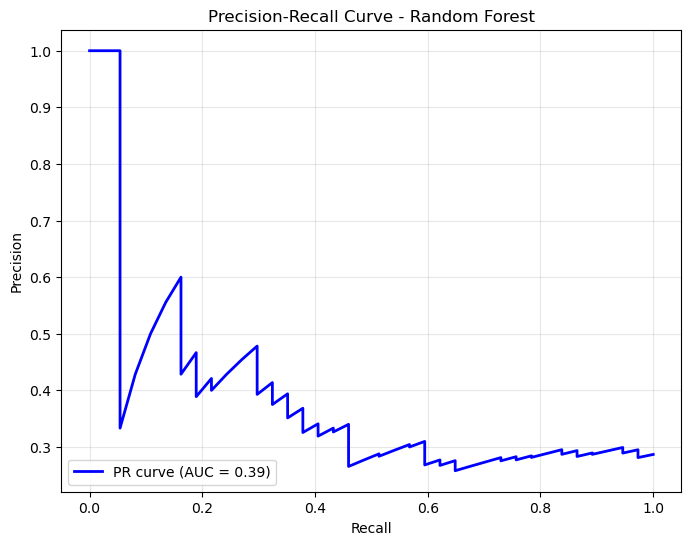

In [2]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Ensure only the original features used during training are passed
X_test_filtered = X_test[['Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]

# Evaluate the best Random Forest model
y_pred_prob = best_rf.predict_proba(X_test_filtered)[:, 1]  # Probability of the positive class (High VVR)

# Compute Precision-Recall curve and PR-AUC for the test set
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()


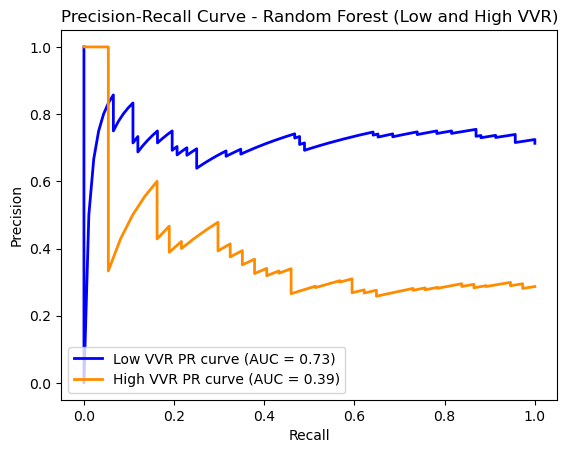

In [4]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Ensure only the original features used during training are passed
X_test_filtered = X_test[['Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]

# Evaluate the best Random Forest model
y_pred_prob = best_rf.predict_proba(X_test_filtered)  # Probabilities for both classes

# Separate probabilities for each class
y_pred_prob_low = y_pred_prob[:, 0]  # Probability of Low VVR (class 0)
y_pred_prob_high = y_pred_prob[:, 1]  # Probability of High VVR (class 1)

# Compute Precision-Recall curves and PR-AUC for both classes
precision_low, recall_low, _ = precision_recall_curve(1 - y_test, y_pred_prob_low)  # For Low VVR
pr_auc_low = average_precision_score(1 - y_test, y_pred_prob_low)

precision_high, recall_high, _ = precision_recall_curve(y_test, y_pred_prob_high)  # For High VVR
pr_auc_high = average_precision_score(y_test, y_pred_prob_high)

# Plot Precision-Recall curves
plt.figure()
plt.plot(recall_low, precision_low, color='blue', lw=2, label=f'Low VVR PR curve (AUC = {pr_auc_low:.2f})')
plt.plot(recall_high, precision_high, color='darkorange', lw=2, label=f'High VVR PR curve (AUC = {pr_auc_high:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest (Low and High VVR)')
plt.legend(loc="lower left")
plt.show()






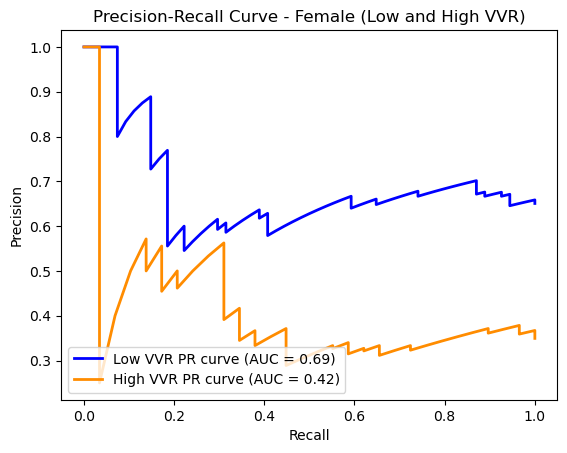

In [17]:
# Female-specific PR curve
gender = 2  # Female
gender_name = gender_labels[gender]
gender_mask = X_test['Gender'] == gender
X_test_gender = X_test_filtered[gender_mask]
y_test_gender = y_test[gender_mask]
y_pred_prob_gender = best_rf.predict_proba(X_test_gender)  # Probabilities for female-specific data

# Separate probabilities for each class
y_pred_prob_low_gender = y_pred_prob_gender[:, 0]  # Probability of Low VVR (class 0)
y_pred_prob_high_gender = y_pred_prob_gender[:, 1]  # Probability of High VVR (class 1)

# Compute PR curves and PR-AUC for Low VVR
precision_low, recall_low, _ = precision_recall_curve(1 - y_test_gender, y_pred_prob_low_gender)
pr_auc_low = average_precision_score(1 - y_test_gender, y_pred_prob_low_gender)

# Compute PR curves and PR-AUC for High VVR
precision_high, recall_high, _ = precision_recall_curve(y_test_gender, y_pred_prob_high_gender)
pr_auc_high = average_precision_score(y_test_gender, y_pred_prob_high_gender)

# Plot PR curves for Female
plt.figure()
plt.plot(recall_low, precision_low, lw=2, color='blue', label=f'Low VVR PR curve (AUC = {pr_auc_low:.2f})')
plt.plot(recall_high, precision_high, lw=2, color='darkorange', label=f'High VVR PR curve (AUC = {pr_auc_high:.2f})')

# Finalize the plot for Female
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Female (Low and High VVR)')
plt.legend(loc="lower left")
plt.show()


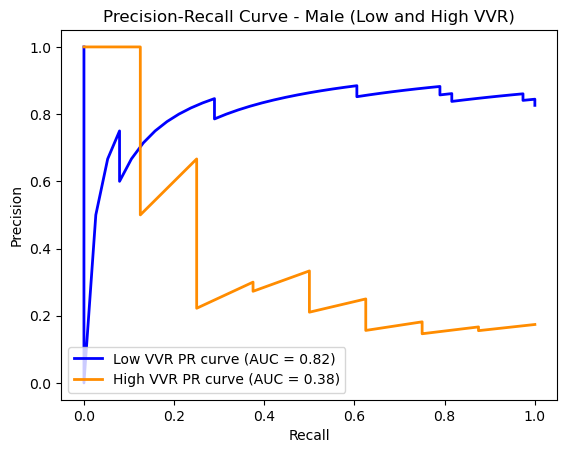

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Define gender labels
gender_labels = {1: 'Male', 2: 'Female'}

# Ensure only the original features used during training are passed
X_test_filtered = X_test[['Prior_Donation', 'Lcheek_max', 'Rcheek_max', 'nose_max', 'chin_max', 'below_nose_max', 'HRV_minmax']]

# Male-specific PR curve
gender = 1  # Male
gender_name = gender_labels[gender]
gender_mask = X_test['Gender'] == gender
X_test_gender = X_test_filtered[gender_mask]
y_test_gender = y_test[gender_mask]
y_pred_prob_gender = best_rf.predict_proba(X_test_gender)  # Probabilities for male-specific data

# Separate probabilities for each class
y_pred_prob_low_gender = y_pred_prob_gender[:, 0]  # Probability of Low VVR (class 0)
y_pred_prob_high_gender = y_pred_prob_gender[:, 1]  # Probability of High VVR (class 1)

# Compute PR curves and PR-AUC for Low VVR
precision_low, recall_low, _ = precision_recall_curve(1 - y_test_gender, y_pred_prob_low_gender)
pr_auc_low = average_precision_score(1 - y_test_gender, y_pred_prob_low_gender)

# Compute PR curves and PR-AUC for High VVR
precision_high, recall_high, _ = precision_recall_curve(y_test_gender, y_pred_prob_high_gender)
pr_auc_high = average_precision_score(y_test_gender, y_pred_prob_high_gender)

# Plot PR curves for Male
plt.figure()
plt.plot(recall_low, precision_low, lw=2, color='blue', label=f'Low VVR PR curve (AUC = {pr_auc_low:.2f})')
plt.plot(recall_high, precision_high, lw=2, color='darkorange', label=f'High VVR PR curve (AUC = {pr_auc_high:.2f})')

# Finalize the plot for Male
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Male (Low and High VVR)')
plt.legend(loc="lower left")
plt.show()
